experience from the 2 notebooks:
- power transform vs. not: clearly power transform
- mean encoding vs. one hot: one hot
- ordinal encoding education_type vs. not: encoding
- smote and adasyn:
    - balance using one and over using other gave bad res, using both gave decent res
    - over `the number of samples (10000) in class 0 will be larger than the number of samples in the majority class`: worsen the res
    - adasyn is only slightly better than smote, high chance that it is due to randomness
    - svmsmote is so bad since the data is not at all linear
    - kmeans smote: bad



# Preparation & Data exploration

In [1]:
! pip install category_encoders --quiet

     |████████████████████████████████| 69 kB 4.3 MB/s 


In [2]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import category_encoders as ce

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PowerTransformer

from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
DIR_PATH = "/content/drive/MyDrive/Colab Notebooks/ML CCC"

RANDOM_STATE = 42

In [4]:
X_train = pd.read_csv(os.path.join(DIR_PATH, 'X_train.csv'))
X_test = pd.read_csv(os.path.join(DIR_PATH, 'X_test.csv'))
y_train = pd.read_csv(os.path.join(DIR_PATH, 'y_train.csv'))
y_test = pd.read_csv(os.path.join(DIR_PATH, 'y_test.csv'))

In [5]:
y_train = y_train.to_numpy().ravel()
y_test = y_test.to_numpy().ravel()

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8252 entries, 0 to 8251
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8252 non-null   int64  
 1   Own_car          8252 non-null   int64  
 2   Own_property     8252 non-null   int64  
 3   Work_phone       8252 non-null   int64  
 4   Phone            8252 non-null   int64  
 5   Email            8252 non-null   int64  
 6   Unemployed       8252 non-null   int64  
 7   Num_children     8252 non-null   int64  
 8   Num_family       8252 non-null   int64  
 9   Account_length   8252 non-null   int64  
 10  Total_income     8252 non-null   float64
 11  Age              8252 non-null   float64
 12  Years_employed   8252 non-null   float64
 13  Income_type      8252 non-null   object 
 14  Education_type   8252 non-null   object 
 15  Family_status    8252 non-null   object 
 16  Housing_type     8252 non-null   object 
 17  Occupation_typ

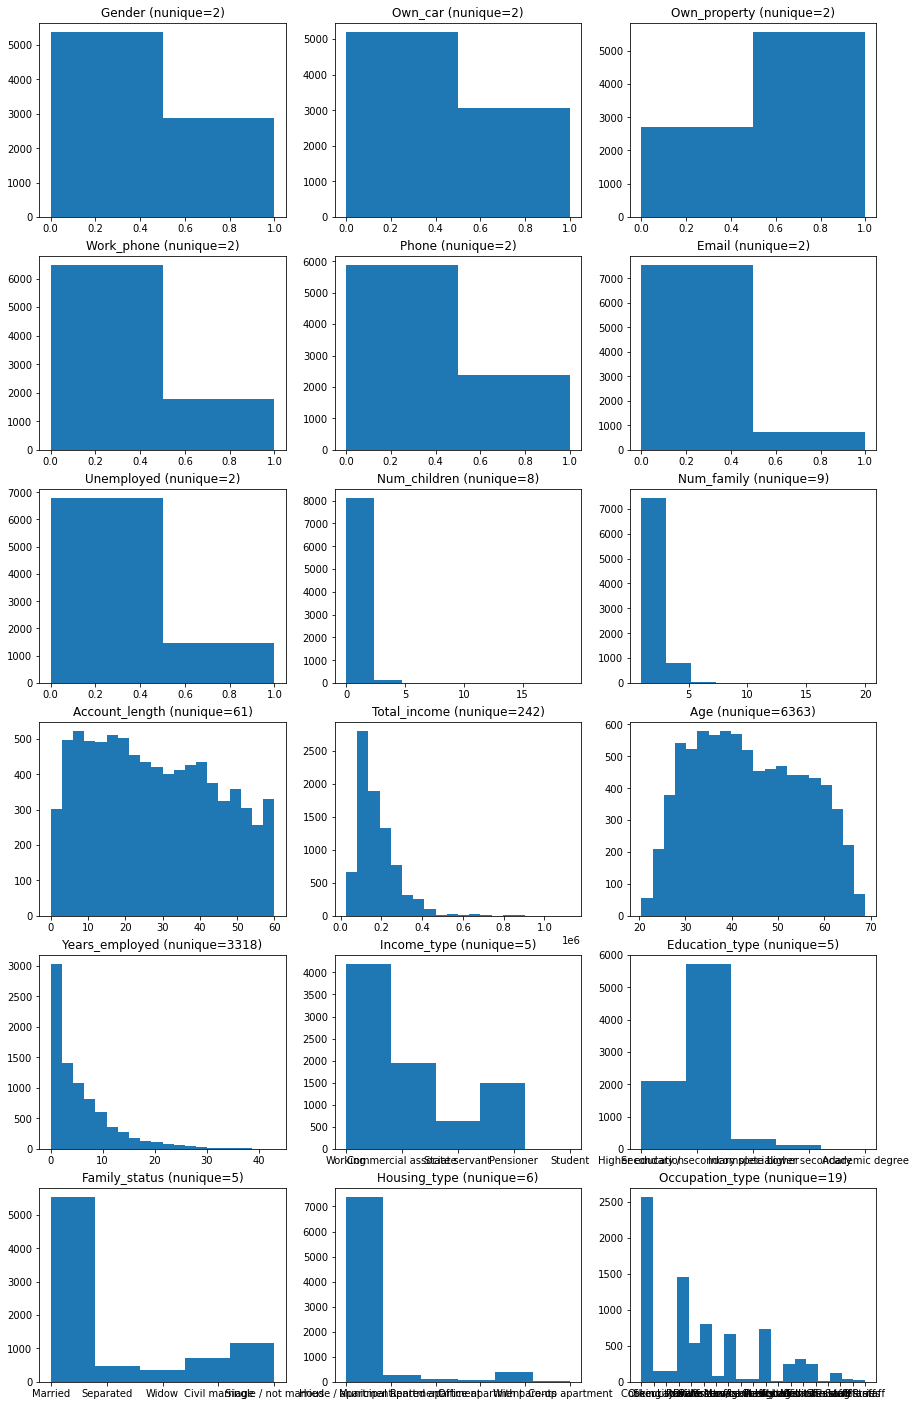

In [7]:
fig, axs = plt.subplots(6, 3, figsize=(15, 25))

for i, column_name in enumerate(X_train):
    column = X_train[column_name]
    nunique = column.nunique()

    axs[i//3, i%3].hist(column, bins=min(nunique, 20))
    axs[i//3, i%3].set_title(f'{column_name} (nunique={nunique})')

In [8]:
CATEGORICAL_COL_NAMES = ['Income_type', 'Education_type', 'Family_status',
                         'Housing_type', 'Occupation_type']
for col_name in CATEGORICAL_COL_NAMES:
    print(X_train[col_name].value_counts())
    print()

Working                 4193
Commercial associate    1951
Pensioner               1482
State servant            624
Student                    2
Name: Income_type, dtype: int64

Secondary / secondary special    5720
Higher education                 2113
Incomplete higher                 312
Lower secondary                   104
Academic degree                     3
Name: Education_type, dtype: int64

Married                 5544
Single / not married    1162
Civil marriage           709
Separated                487
Widow                    350
Name: Family_status, dtype: int64

House / apartment      7383
With parents            375
Municipal apartment     271
Rented apartment        125
Office apartment         67
Co-op apartment          31
Name: Housing_type, dtype: int64

Other                    2565
Laborers                 1452
Sales staff               804
Core staff                738
Managers                  666
Drivers                   532
High skill tech staff     319
Acco

In [9]:
X_train.head()

,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type
0,0,0,1,0,0,0,0,0,2,59,202500.0,31.409269,1.631793,Working,Higher education,Married,House / apartment,Other
1,0,1,1,0,0,0,0,1,3,59,130500.0,38.746860,15.222763,Working,Secondary / secondary special,Married,House / apartment,Cooking staff
2,1,0,0,1,1,0,0,1,3,6,180000.0,39.428599,2.680411,Commercial associate,Secondary / secondary special,Married,House / apartment,Security staff
3,1,0,1,0,0,0,0,1,2,1,99000.0,40.208902,0.793993,Working,Secondary / secondary special,Separated,House / apartment,Laborers
4,0,0,1,0,0,0,0,3,5,42,179100.0,36.255365,5.002156,State servant,Secondary / secondary special,Married,House / apartment,Cooking staff


In [10]:
X_train.shape

(8252, 18)

(array([7162.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1090.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

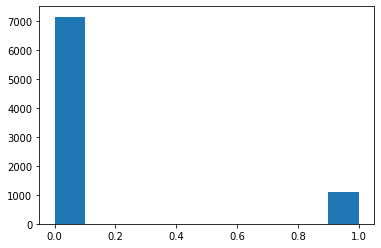

In [11]:
plt.hist(y_train)

#power transform
Num_children to Years_employed   

In [12]:
X_train_filtered = X_train.loc[:, 'Num_children':'Years_employed']
X_train_filtered

,Num_children,Num_family,Account_length,Total_income,Age,Years_employed
0,0,2,59,202500.0,31.409269,1.631793
1,1,3,59,130500.0,38.746860,15.222763
2,1,3,6,180000.0,39.428599,2.680411
3,1,2,1,99000.0,40.208902,0.793993
4,3,5,42,179100.0,36.255365,5.002156
...,...,...,...,...,...,...
8247,0,2,2,225000.0,31.803528,9.155561
8248,0,2,51,202500.0,40.277350,17.591053
8249,0,2,37,157500.0,64.789831,0.000000
8250,1,3,53,225000.0,41.769509,23.721226


In [13]:
transformer = PowerTransformer()
X_train_filtered_transformed = transformer.fit_transform(X_train_filtered)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [14]:
X_train.loc[:, 'Num_children':'Years_employed'] = X_train_filtered_transformed

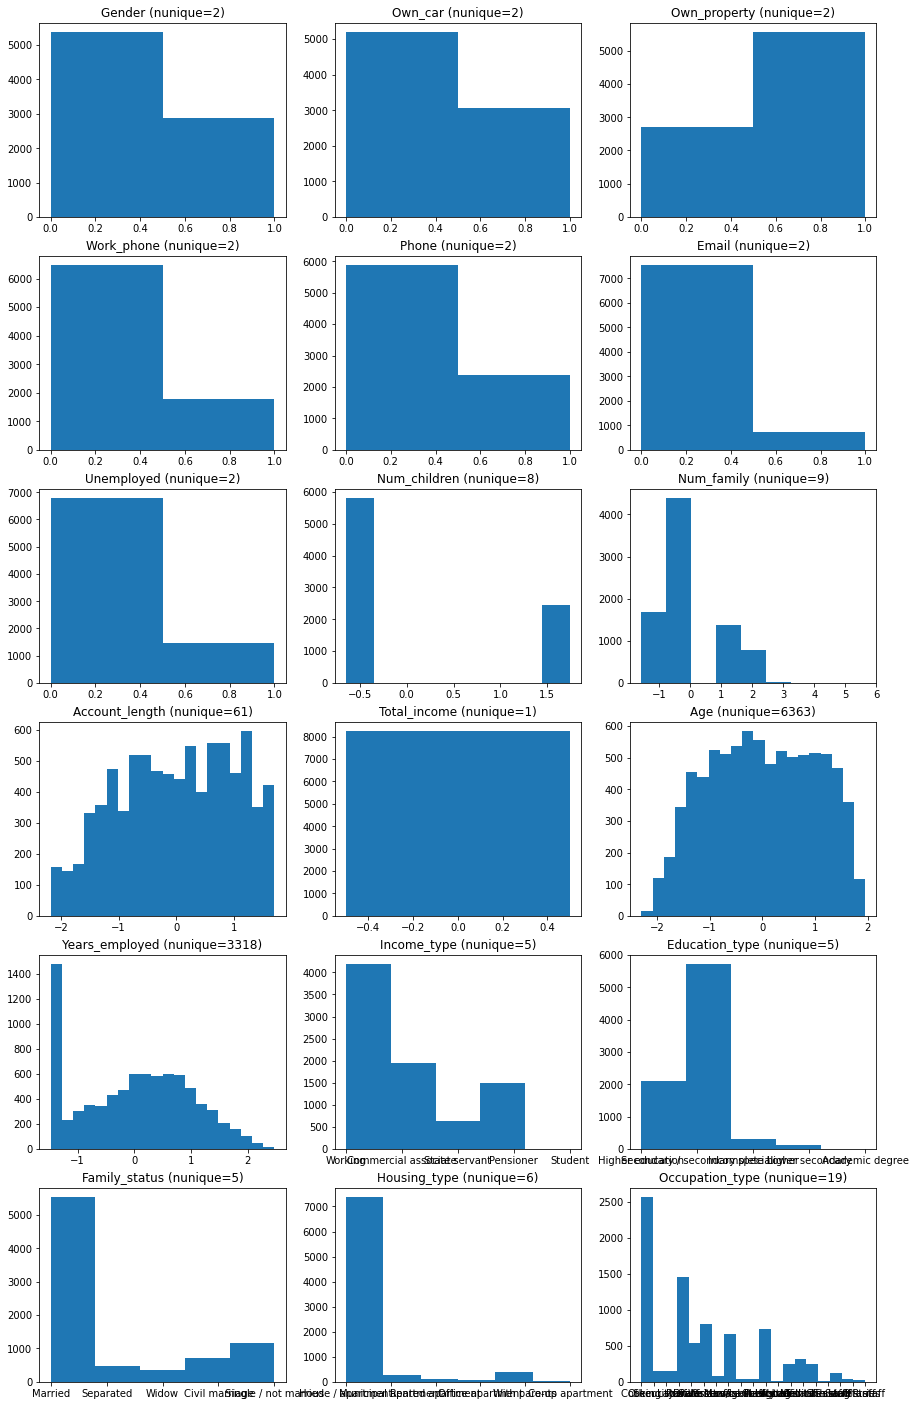

In [15]:
fig, axs = plt.subplots(6, 3, figsize=(15, 25))

for i, column_name in enumerate(X_train):
    column = X_train[column_name]
    nunique = column.nunique()

    axs[i//3, i%3].hist(column, bins=min(nunique, 20))
    axs[i//3, i%3].set_title(f'{column_name} (nunique={nunique})')

In [ ]:
X_test_filtered_transformed = transformer.transform(
    X_test.loc[:, 'Num_children':'Years_employed'])

In [ ]:
X_test.loc[:, 'Num_children':'Years_employed'] = X_test_filtered_transformed

# mean encoding
mean encoding idea is taken from https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02

In [ ]:
X_train_w_target = X_train.copy(deep=True)
X_train_w_target['target'] = y_train

In [ ]:
mean_encoding_maps = dict()

In [ ]:
def get_mean_encoding_map(feature_name):
    if feature_name not in mean_encoding_maps:
        mean_encoding_maps[feature_name] = \
                X_train_w_target.groupby(feature_name)['target'].mean()
    return mean_encoding_maps[feature_name]

In [ ]:
for feature_name in [
        'Education_type', 'Income_type', 'Family_status',
        'Housing_type', 'Occupation_type']:
    mean_encoding_map = get_mean_encoding_map(feature_name)
    print(mean_encoding_map)
    print()

    X_train[feature_name] = X_train[feature_name].map(mean_encoding_map)

Education_type
Academic degree                  0.333333
Higher education                 0.137246
Incomplete higher                0.169872
Lower secondary                  0.125000
Secondary / secondary special    0.128147
Name: target, dtype: float64

Income_type
Commercial associate    0.138903
Pensioner               0.124157
State servant           0.120192
Student                 0.000000
Working                 0.133556
Name: target, dtype: float64

Family_status
Civil marriage          0.150917
Married                 0.127525
Separated               0.125257
Single / not married    0.150602
Widow                   0.114286
Name: target, dtype: float64

Housing_type
Co-op apartment        0.096774
House / apartment      0.129893
Municipal apartment    0.158672
Office apartment       0.119403
Rented apartment       0.176000
With parents           0.146667
Name: target, dtype: float64

Occupation_type
Accountants              0.138889
Cleaning staff           0.118644
Cooking st

In [ ]:
X_train.head()

,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type
0,0,0,1,0,0,0,0,-0.647202,-0.037197,1.657132,0.0,-1.076036,-0.517422,0.133556,0.137246,0.127525,0.129893,0.123977
1,0,1,1,0,0,0,0,1.468683,0.972997,1.657132,0.0,-0.375764,1.377522,0.133556,0.128147,0.127525,0.129893,0.158940
2,1,0,0,1,1,0,0,1.468683,0.972997,-1.383327,0.0,-0.314287,-0.177692,0.138903,0.128147,0.127525,0.129893,0.162338
3,1,0,1,0,0,0,0,1.468683,-0.037197,-1.991669,0.0,-0.244586,-0.900427,0.133556,0.128147,0.125257,0.129893,0.133609
4,0,0,1,0,0,0,0,1.710836,2.286411,0.895521,0.0,-0.605282,0.325524,0.120192,0.128147,0.127525,0.129893,0.158940


# TEST: bagging

In [ ]:
# X_test['Education_type'] = X_test['Education_type'].map(education_type_map)

for feature_name in [
        'Education_type',
        'Income_type', 'Family_status', 'Housing_type', 'Occupation_type']:
    mean_encoding_map = get_mean_encoding_map(feature_name)

    X_test[feature_name] = X_test[feature_name].map(mean_encoding_map)

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457 entries, 0 to 1456
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           1457 non-null   int64  
 1   Own_car          1457 non-null   int64  
 2   Own_property     1457 non-null   int64  
 3   Work_phone       1457 non-null   int64  
 4   Phone            1457 non-null   int64  
 5   Email            1457 non-null   int64  
 6   Unemployed       1457 non-null   int64  
 7   Num_children     1457 non-null   float64
 8   Num_family       1457 non-null   float64
 9   Account_length   1457 non-null   float64
 10  Total_income     1457 non-null   float64
 11  Age              1457 non-null   float64
 12  Years_employed   1457 non-null   float64
 13  Income_type      1457 non-null   float64
 14  Education_type   1457 non-null   float64
 15  Family_status    1457 non-null   float64
 16  Housing_type     1457 non-null   float64
 17  Occupation_typ

In [ ]:
bag = BaggingClassifier(n_estimators=100, random_state=RANDOM_STATE)\
    .fit(X_train, y_train)

In [ ]:
fbeta_score(y_test, bag.predict(X_test), beta=2)

0.00639386189258312

In [ ]:
bag.score(X_test, y_test)

0.8620452985586822

# TEST: smote

In [ ]:
smote = SMOTE(# sampling_strategy={0: 10000, 1:10000},
              random_state=RANDOM_STATE)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

(array([7162.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        7162.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

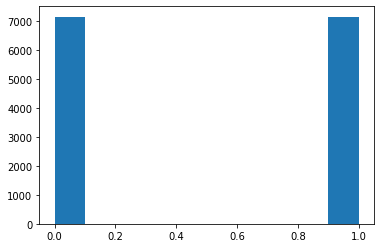

In [ ]:
plt.hist(y_train_over)

In [ ]:
bag = BaggingClassifier(n_estimators=100, random_state=RANDOM_STATE)\
    .fit(X_train_over, y_train_over)

In [ ]:
fbeta_score(y_test, bag.predict(X_test), beta=2)

0.03048780487804878

In [ ]:
bag.score(X_test, y_test)

0.8414550446122169

# VIZ

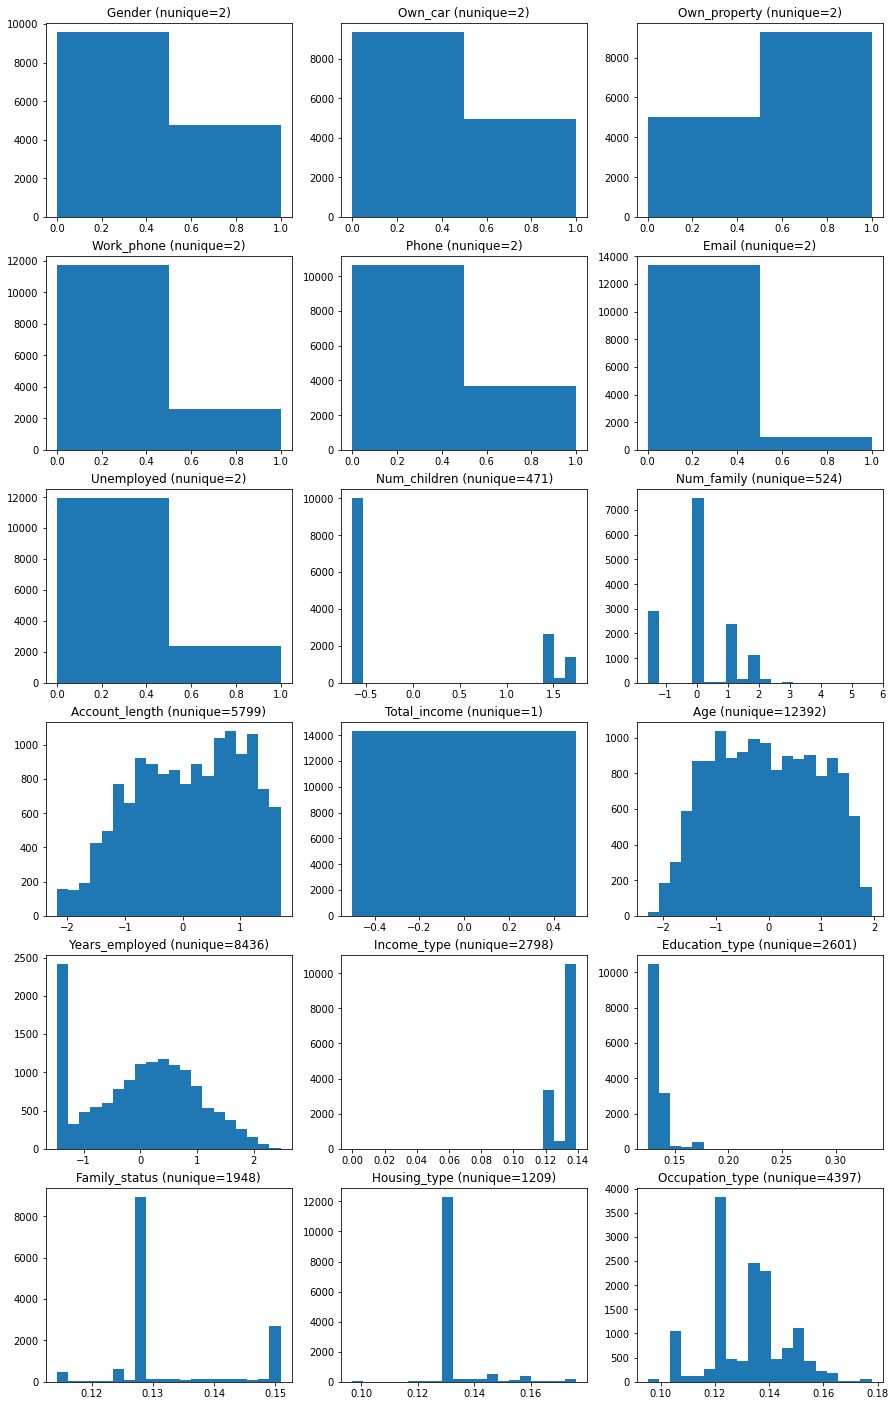

In [ ]:
fig, axs = plt.subplots(6, 3, figsize=(15, 25))

for i, column_name in enumerate(X_train):
    column = X_train_over[column_name]
    nunique = column.nunique()

    axs[i//3, i%3].hist(column, bins=min(nunique, 20))
    axs[i//3, i%3].set_title(f'{column_name} (nunique={nunique})')

# TEST RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators=50, 
                            max_depth=5,
                            random_state=RANDOM_STATE).fit(X_train_over, y_train_over)

In [ ]:
fbeta_score(y_test, rf.predict(X_test), beta=2)

0.1128668171557562

In [ ]:
confusion_matrix(y_test, rf.predict(X_test))

array([[1170,   94],
       [ 173,   20]])

In [ ]:
fbeta_score(y_train, rf.predict(X_train), beta=2)

0.13028663058729206

In [ ]:
rf.feature_importances_

array([0.00272823, 0.00268075, 0.00498929, 0.0158346 , 0.00462775,
       0.00574124, 0.00039747, 0.00762965, 0.00917691, 0.13850327,
       0.        , 0.01376681, 0.01580041, 0.18239243, 0.28009574,
       0.149403  , 0.06520461, 0.10102784])

# WITHOUT Ordinal encoding Education_type

In [ ]:
assert False

AssertionError: ignored

In [ ]:
education_type_map = {
    'Lower secondary': 0,
    'Secondary / secondary special': 1,
    'Incomplete higher': 2,
    'Higher education': 3,
    'Academic degree': 4
}
X_train['Education_type'] = X_train['Education_type'].map(education_type_map)

In [ ]:
X_train.head()